<a href="https://colab.research.google.com/github/koksal100/NLP/blob/main/ABSE_WITH_TWITTER_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
import matplotlib.pyplot as plt
# NLTK stopwords ve diğer bileşenleri indir
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
tweets=pd.read_csv("tweets.csv")

In [3]:
tweets.drop("Unnamed: 0",axis=1,inplace=True)

In [4]:
tweets

,yanıt sayısı,yeniden gönderi sayısı,beğeni sayısı,yer işareti sayısı,görüntülenme sayısı,user_name,nick,date,Tweet
0,4,44,260,2,3102,@OlympicEsporte,Olympic Esporte,10d,TATI WESTON WEBB NA SEMIFINAL OLÍMPICA \n\nTat...
1,32,46,251,5,3377,@OliLondonTV,Oli London,10d,"Dear Paris Olympics,\n\nJust in case you need ..."
2,37,46,232,1,26268,@ClayTravis,Clay Travis,15d,After a full day of virtual silence \n@ESPN\n ...
3,19,36,249,7,53951,@NBCOlympics,NBC Olympics & Paralympics,29d,Simone Biles made a STATEMENT on beam in the a...
4,8,27,182,2,5021,@mymixtapez,My Mixtapez,52d,LeBron James is the first self-made billionair...
...,...,...,...,...,...,...,...,...,...
1865,6,29,195,2,36365,@TheCalvinCooli1,The Calvin Coolidge Project,12s,"In my opinion, Angela Carini should sue the Ol..."
1866,19,24,325,18,24385,@TheCartelDel,Del Walker,12s,I DO NOT like the US method of Olympic comment...
1867,7,61,244,22,18620,@VDHanson,Victor Davis Hanson,12s,On The VDH Show: Hezbollah rockets hit Israeli...
1868,71,96,258,6,15526,@WallStreetApes,Wall Street Apes,12s,You can always count on the mainstream media t...


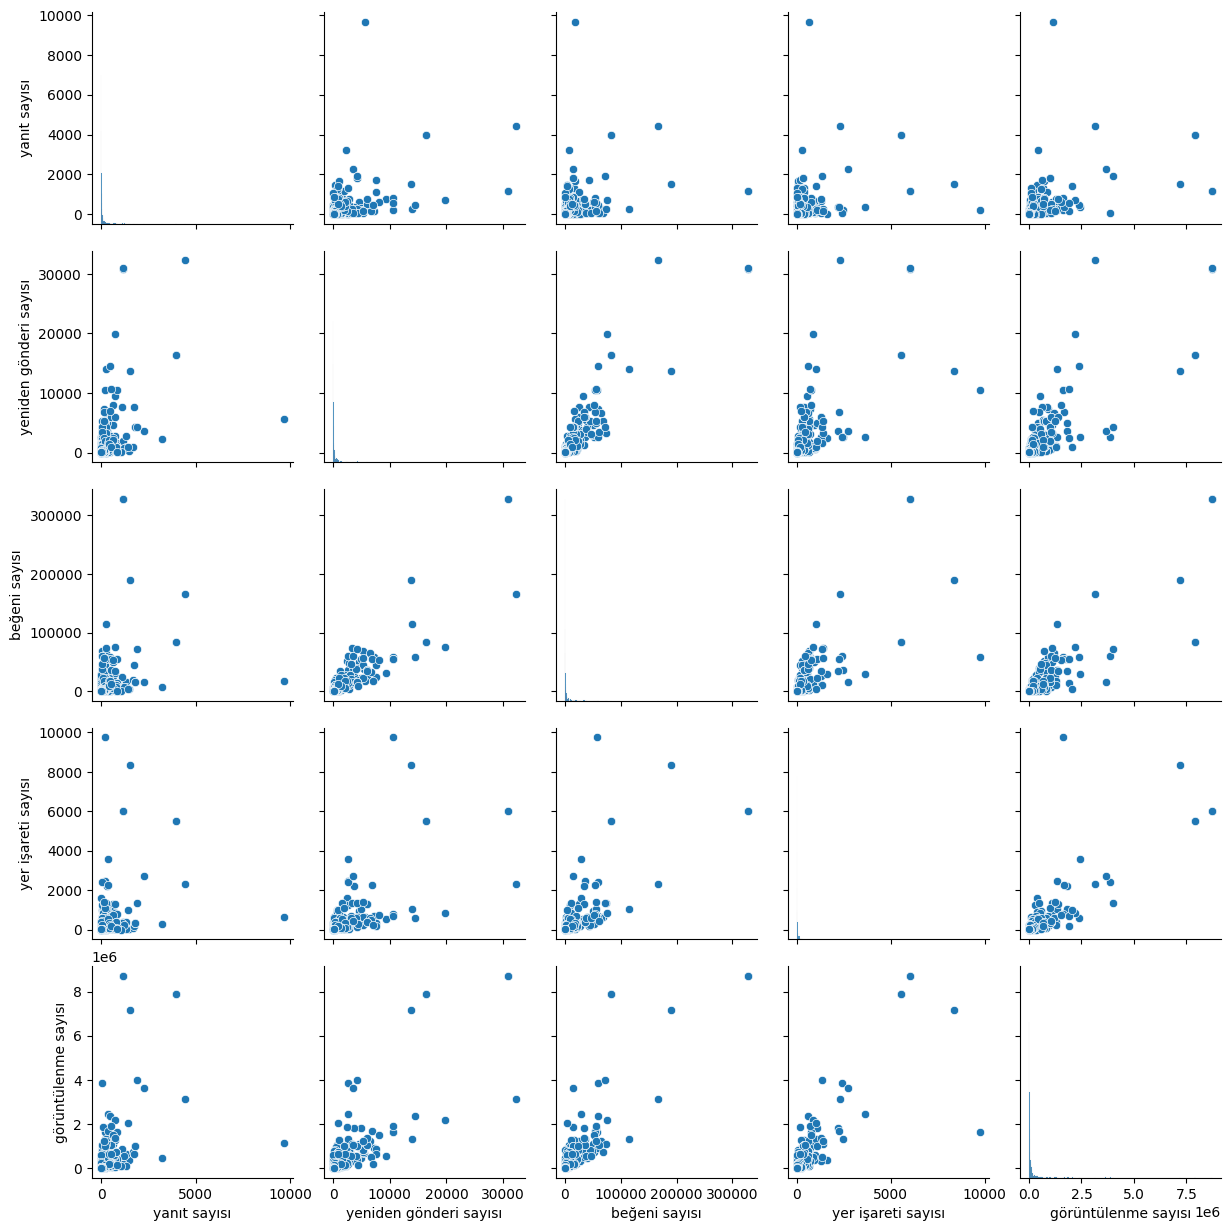

In [123]:
# prompt: tweets veri çerçevesi kullanılıyor: ilk 5 columun birbirine göre grafikleri

import seaborn as sns
import matplotlib.pyplot as plt

# İlk 5 sütunu seçiyoruz
ilk_bes_sutun = tweets.iloc[:, :5]

# Her bir sütun çiftini scatter plot ile görselleştiriyoruz
sns.pairplot(ilk_bes_sutun)
plt.show()


In [5]:
def preprocess_tweet(tweet):
    # Küçük harfe çevir
    tweet = tweet.lower()

    # URL'leri kaldır
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)

    # Kullanıcı adlarını kaldır
    tweet = re.sub(r'@\w+', '', tweet)

    # Hashtag'leri kaldır
    tweet = re.sub(r'#\w+', '', tweet)

    # Özel karakterleri ve noktalama işaretlerini kaldır
    tweet = re.sub(r'[^\w\s]', '', tweet)

    # Kelime köklerine ayırma
    stemmer = SnowballStemmer('english')
    tweet = ' '.join(stemmer.stem(word) for word in tweet.split())

    # Boşlukları temizle
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    return tweet


In [6]:
tweets['Tweet_Preprocessed'] = tweets['Tweet'].apply(preprocess_tweet)

In [7]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [8]:
def get_sentiment(text):
    try:
        result = pipe(text[:512])  # Truncate text to avoid exceeding model's input size
        return result[0]["label"], result[0]["score"]
    except:
        return "Error", "NaN"  # Handle potential errors gracefully


tweets["sentiment"], tweets["score"] = zip(*tweets["Tweet_Preprocessed"].apply(get_sentiment))

In [9]:
tweets["sentiment"].value_counts()

,count
sentiment,
neutral,890
negative,567
positive,411
Error,2


In [11]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/distilbert-NER")
model_ner = AutoModelForTokenClassification.from_pretrained("dslim/distilbert-NER")

nlp_ner = pipeline("ner", model=model_ner, tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/926 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

In [12]:
tweets["Tweet"].iloc[256]

'What is Saka doing at the Olympics?'

In [13]:
tweets["Tweet_Preprocessed"].iloc[256]

'what is saka do at the olymp'

In [14]:
nlp_ner(tweets["Tweet_Preprocessed"].iloc[256])

[]

In [37]:
pipe = pipeline("token-classification", model="dslim/bert-large-NER")

config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-large-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [40]:
pipe(tweets["Tweet"].iloc[256])

[{'entity': 'B-PER',
  'score': 0.9341293,
  'index': 3,
  'word': 'Sa',
  'start': 8,
  'end': 10},
 {'entity': 'I-PER',
  'score': 0.32781708,
  'index': 4,
  'word': '##ka',
  'start': 10,
  'end': 12},
 {'entity': 'B-MISC',
  'score': 0.98203206,
  'index': 8,
  'word': 'Olympics',
  'start': 26,
  'end': 34}]

In [39]:
tweets["Tweet_Preprocessed"].iloc[256]

'what is saka do at the olymp'

In [23]:
tweets["Tweet"].iloc[200:220]

,Tweet
200,Andrey Rublev posts on Instagram about the boxing at the Olympics
201,L'ITALIA CONTINUA A EMOZIONARE! \n\nEcco la Top10 della sesta giornata a Parigi!\n\nDue ori e un argento il bottino azzurro \n\n#Paris2024 #Olympics #HomeOfTheOlympics #Olimpiadi #Parigi2024 \n@discoveryplusIT
202,oscar showing up to the paddock in zandvoort with his olympic medals
203,they get banned from the olympics and immediately start innovating. the russian spirit truly cannot be tamed
204,i drew this during the 2016 Olympics.
205,"Kevin Piette, paraplegic since an accident, made history by carrying the Olympic flame with his Al-powered exoskeleton."
206,"MAGA lunatics are now focusing their efforts on attacking a female Olympic boxer for being transgender even though she is a woman who was born with an extremely rare condition that creates an XXY chromosome.\n\nThe hatred, bigotry and ignorance of these unhinged idiots is endless."
207,"Rose Yeboah will compete in High Jump for Ghana on Friday. \n\nSome context on why this is a big deal. \n\n First woman to compete in High Jump at the Olympics for Ghana and only the third athlete to get this far. The last athlete to represent Ghana was all the way back in 1960. \n\n African Games Gold medalist (2019, 2023) \n\n African Athletics Championship (Douala) Gold medalist \n\n The jump that got her the Olympic ticket is one of the best jumps ever in the NCAA. Done at the Hayward Field in Eugene, Oregon \n\n The latest World Athletics ranking for High Jump has her in 7th position in the world. \n\n Gold at the World University Games in Chengdu in 2021 \n\nAll the best to a lady who has taken this sport by storm. \n\n#OlympicGames"
208,"Why I’m disgusted by Donald Trump’s NABJ interview, Kamala race comments, Olympics, more"
209,"Boxer Imane Khelif is a cisgender woman. So why are famed transphobes like J.K. Rowling, J.D. Vance, and Donald Trump attacking her for competing at the Olympics?"


In [42]:
pipe(tweets["Tweet"].iloc[209])

[{'entity': 'B-PER',
  'score': 0.99882454,
  'index': 3,
  'word': 'I',
  'start': 6,
  'end': 7},
 {'entity': 'I-PER',
  'score': 0.70569515,
  'index': 4,
  'word': '##man',
  'start': 7,
  'end': 10},
 {'entity': 'I-PER',
  'score': 0.9854453,
  'index': 5,
  'word': '##e',
  'start': 10,
  'end': 11},
 {'entity': 'I-PER',
  'score': 0.999342,
  'index': 6,
  'word': 'K',
  'start': 12,
  'end': 13},
 {'entity': 'I-PER',
  'score': 0.9969452,
  'index': 7,
  'word': '##hel',
  'start': 13,
  'end': 16},
 {'entity': 'I-PER',
  'score': 0.99133223,
  'index': 8,
  'word': '##if',
  'start': 16,
  'end': 18},
 {'entity': 'B-PER',
  'score': 0.9945522,
  'index': 26,
  'word': 'J',
  'start': 75,
  'end': 76},
 {'entity': 'I-PER',
  'score': 0.96909684,
  'index': 28,
  'word': 'K',
  'start': 77,
  'end': 78},
 {'entity': 'I-PER',
  'score': 0.75804424,
  'index': 29,
  'word': '.',
  'start': 78,
  'end': 79},
 {'entity': 'I-PER',
  'score': 0.9968727,
  'index': 30,
  'word': 'Row',

In [55]:
def merge_entities(entities):
    merged = []
    current_entity = None
    current_word=""
    for entity in entities:
        if entity["entity"][0]=="B":
            if current_entity:
                merged.append({"entity": current_entity, "word": current_word})
            current_entity=entity["entity"][2:]
            current_word=entity["word"]
        elif entity["entity"][0]=="I" and entity["entity"][2:]==current_entity:
            if entity["word"][:2]=="##":
                current_word+=entity["word"][2:]
            else:
                current_word+=" "+entity["word"]

    return merged

In [58]:
merged_results = merge_entities(pipe(tweets["Tweet"].iloc[209]))
merged_results

[{'entity': 'PER', 'word': 'Imane Khelif'},
 {'entity': 'PER', 'word': 'J K . Rowling'},
 {'entity': 'PER', 'word': 'J D . Vance'},
 {'entity': 'PER', 'word': 'Donald Trump'}]

In [59]:
tweets["Ner_results"]=tweets["Tweet"].apply(lambda x:merge_entities(pipe(x)))

In [60]:
pipe_absa = pipeline("text-classification", model="yangheng/deberta-v3-large-absa-v1.1")

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [63]:
pipe_absa(tweets["Tweet"].iloc[209],text_pair="Donald Trump")

[{'label': 'Negative', 'score': 0.7309128642082214}]

In [69]:
tweets["Tweet"].iloc[417]

' Andy Murray \n\nA true champion whose legacy will echo through history forever. \n\n#Paris2024 | #Olympics | #tennis | #andymurray'

In [68]:
pipe_absa(tweets["Tweet"].iloc[417],text_pair="Andy Murray")

[{'label': 'Positive', 'score': 0.9999085664749146}]

In [88]:
positive_dict={}
negative_dict={}
for i in range(len(tweets)):
    if i%100==0:
        print("%", i/len(tweets), "tamamlandı")
    results=tweets["Ner_results"].iloc[i]
    for result in results:
        if result["entity"]=="PER":
            word=result["word"]
            resultOfAbsa=pipe_absa(tweets["Tweet"].iloc[i],text_pair=word)
            print(resultOfAbsa)
            if resultOfAbsa[0]["label"]=="Positive":
                if word in positive_dict:
                    positive_dict[word]+=resultOfAbsa[0]["score"]
                else:
                    positive_dict[word]=resultOfAbsa[0]["score"]
            elif resultOfAbsa[0]["label"]=="Negative":
                if word in negative_dict:
                    negative_dict[word]+=resultOfAbsa[0]["score"]
                else:
                    negative_dict[word]=resultOfAbsa[0]["score"]

% 0.0 tamamlandı
[{'label': 'Neutral', 'score': 0.9472166299819946}]
[{'label': 'Neutral', 'score': 0.9956303834915161}]
[{'label': 'Neutral', 'score': 0.9917123317718506}]
[{'label': 'Positive', 'score': 0.8880360722541809}]
[{'label': 'Neutral', 'score': 0.7268561124801636}]
[{'label': 'Positive', 'score': 0.6256746053695679}]
[{'label': 'Neutral', 'score': 0.9995706677436829}]
[{'label': 'Neutral', 'score': 0.7212873101234436}]
[{'label': 'Negative', 'score': 0.6541466116905212}]
[{'label': 'Neutral', 'score': 0.5000572204589844}]
[{'label': 'Neutral', 'score': 0.7212873101234436}]
[{'label': 'Negative', 'score': 0.6541466116905212}]
[{'label': 'Positive', 'score': 0.7426837682723999}]
[{'label': 'Positive', 'score': 0.9990490078926086}]
[{'label': 'Neutral', 'score': 0.9970792531967163}]
[{'label': 'Neutral', 'score': 0.9112643003463745}]
[{'label': 'Neutral', 'score': 0.9724094867706299}]
[{'label': 'Neutral', 'score': 0.9974011182785034}]
[{'label': 'Negative', 'score': 0.6151373

In [89]:
positive_dict

{'Boebert': 0.8880360722541809,
 '##ntina Gomez': 0.6256746053695679,
 'Mike Tyson': 0.7426837682723999,
 'Caeleb Dressel': 0.9990490078926086,
 'Lauren Scruggs': 1.7891830205917358,
 'Simone Biles': 59.62615931034088,
 'Michaela Tyson': 1.7253143787384033,
 'Justin Best': 1.9984732270240784,
 'Summer': 2.662551760673523,
 'McIntosh': 1.9350191354751587,
 'Regan Smith': 5.0298314690589905,
 'Novak Djokovic': 7.244566082954407,
 'Zheng Qinwen': 1.6373934149742126,
 'EllieBla': 0.8071147799491882,
 'Vale': 0.5738887786865234,
 '##ntina': 0.6203711032867432,
 'fnis': 0.8317946195602417,
 'Mr Bean': 1.9973053932189941,
 'Katie Ledecky': 13.526187181472778,
 'Simone': 8.63427996635437,
 'Suni Lee': 6.125799238681793,
 'Jake Shields': 0.9983068704605103,
 'Michael Phelps': 0.9986263513565063,
 'Ariarne Titmus': 1.990014135837555,
 '##e Khelif': 0.6532403826713562,
 'Sun': 5.491040647029877,
 '##i Lee': 5.883993625640869,
 'Zhang Zhizhen': 0.7953242659568787,
 'Wang Xinyu': 0.8262963891029358

In [90]:
negative_dict

{'##rit': 1.3082932233810425,
 'I': 17.441960245370865,
 '##mane Khelif': 11.760658740997314,
 'Kamal': 5.940181612968445,
 'Trump': 1.999087929725647,
 'Iman': 10.514972388744354,
 '##e': 1.507893443107605,
 'Medina': 0.8524091839790344,
 'Angela Carini': 25.220727682113647,
 'IS': 0.4298214614391327,
 '”': 0.6079332232475281,
 '##e Khelif': 14.2283293902874,
 'Tom Cruise': 1.576770305633545,
 'Jesus': 2.920479118824005,
 'Imane Khelif': 17.877574265003204,
 'Lin Yu ting': 1.6533063650131226,
 '##a Harris': 2.920010507106781,
 'Mike Tyson': 4.6341469287872314,
 'JK Rowling': 1.7134544849395752,
 'Khelif': 21.647437632083893,
 'Deontay': 0.9719675779342651,
 'J K . Rowling': 1.5427253246307373,
 'J D . Vance': 2.986544668674469,
 'Donald Trump': 2.461503505706787,
 'Colin Jost': 0.9661576747894287,
 'Kamala': 2.9731330275535583,
 'Ke': 2.9452085494995117,
 'Elon': 0.9919378161430359,
 'Angela': 0.9839150905609131,
 'Murray': 0.997349739074707,
 'Harris Biden': 0.9674500823020935,
 'JD 

In [91]:
import json

# Dictionary'yi JSON formatında bir dosyaya kaydetme
with open('positive_dict.json', 'w') as f:
    json.dump(positive_dict, f)


# Dictionary'yi JSON formatında bir dosyaya kaydetme
with open('negative_dict.json', 'w') as f:
    json.dump(negative_dict, f)

In [118]:
tweets.to_csv("tweets_New.csv",index=False)

In [128]:
def visualize_dict(data,isPositive):
  # Sözlüğü değerlerine göre sıralamak
    sorted_data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))

    # En yüksek değere sahip 10 anahtarı seçmek
    top_10_keys = list(sorted_data.keys())[:10]
    top_10_values = list(sorted_data.values())[:10]

    # Görselleştirmek
    plt.figure(figsize=(10, 5))
    plt.bar(top_10_keys, top_10_values, color='blue')
    plt.xlabel('Persons')
    plt.ylabel('Values')
    plt.xticks(rotation=90)
    if isPositive:
        plt.title('Top 10 Positive Values')
    else:
        plt.title('Top 10 Negative Values')
    plt.show()


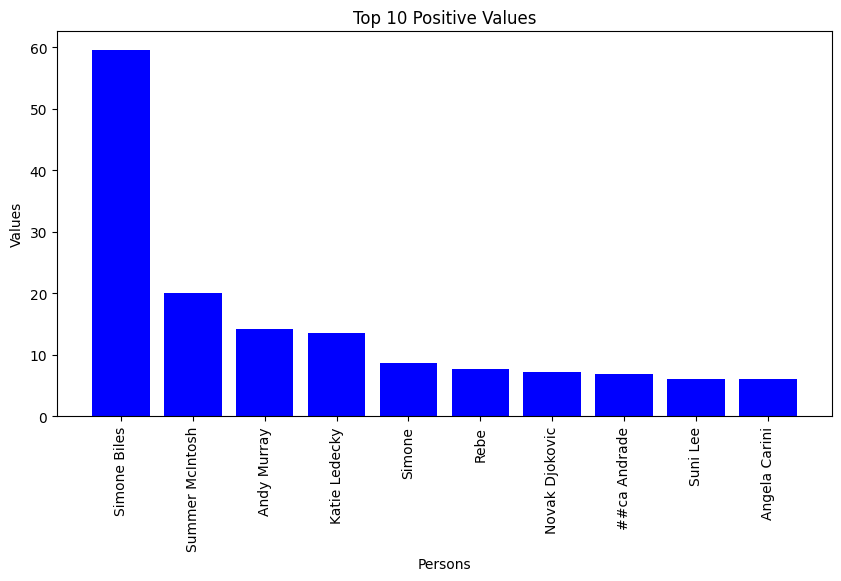

In [129]:
visualize_dict(positive_dict,True)

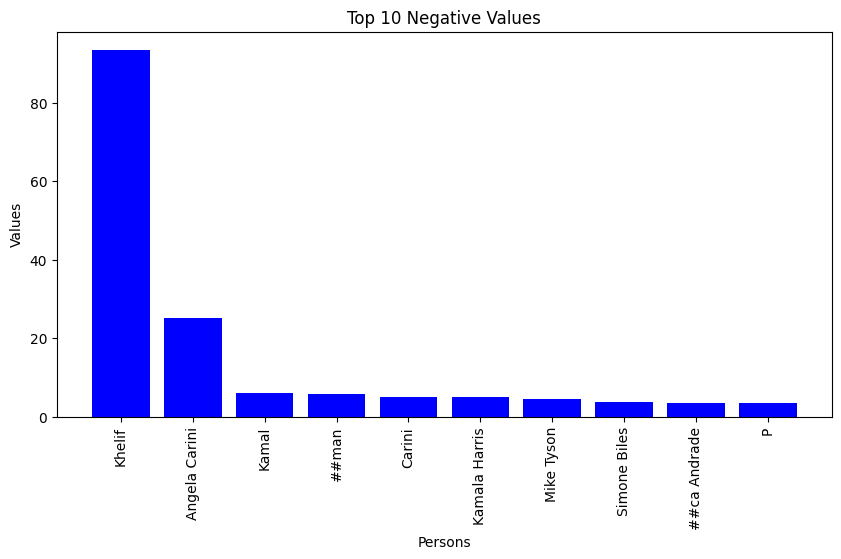

In [131]:
visualize_dict(negative_dict,False)

In [100]:
sorted_data = dict(sorted(negative_dict.items(), key=lambda item: item[1], reverse=True))

In [112]:
same_keys=list(sorted_data.keys())[1:7]
same_keys

['Khelif', 'Imane Khelif', 'I', '##e Khelif', '##mane Khelif', 'Iman']

In [111]:
##ALL THESE KEYS BELONG TO THE SAME PERSON SO DICTIONARY MUST VE REVISED

In [113]:
for key in same_keys[1:]:
    negative_dict[same_keys[0]]+=negative_dict[key]
    del negative_dict[key]
print(negative_dict)


{'##rit': 1.3082932233810425, 'Kamal': 5.940181612968445, 'Trump': 1.999087929725647, '##e': 1.507893443107605, 'Medina': 0.8524091839790344, 'Angela Carini': 25.220727682113647, 'IS': 0.4298214614391327, '”': 0.6079332232475281, 'Tom Cruise': 1.576770305633545, 'Jesus': 2.920479118824005, 'Lin Yu ting': 1.6533063650131226, '##a Harris': 2.920010507106781, 'Mike Tyson': 4.6341469287872314, 'JK Rowling': 1.7134544849395752, 'Khelif': 93.47093266248703, 'Deontay': 0.9719675779342651, 'J K . Rowling': 1.5427253246307373, 'J D . Vance': 2.986544668674469, 'Donald Trump': 2.461503505706787, 'Colin Jost': 0.9661576747894287, 'Kamala': 2.9731330275535583, 'Ke': 2.9452085494995117, 'Elon': 0.9919378161430359, 'Angela': 0.9839150905609131, 'Murray': 0.997349739074707, 'Harris Biden': 0.9674500823020935, 'JD Vance': 1.6287484169006348, 'Saka': 0.7580953240394592, 'Ben': 0.8238401412963867, 'van de Velde': 0.9993135929107666, 'Grousset': 0.9968233108520508, 'Luca Anna Hamori': 0.6607517600059509,

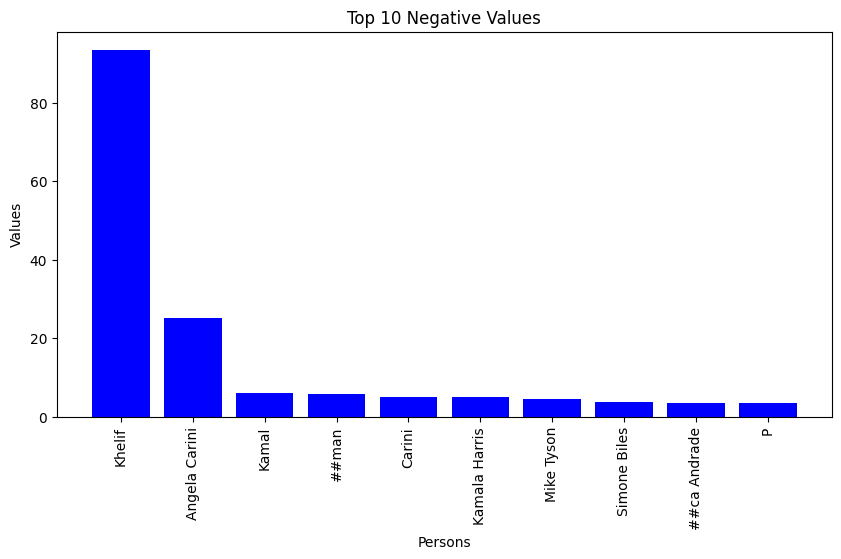

In [132]:
visualize_dict(negative_dict,False)

In [137]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def visualize_top_10_keys(data,isPositive):
    """
    Verilen sözlükteki en yüksek değere sahip 10 anahtarı kelime bulutu olarak görselleştirir.

    Args:
    data (dict): Anahtar-değer çiftlerinden oluşan sözlük.

    Returns:
    None
    """
    # Sözlüğü değerlerine göre sıralamak
    sorted_data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))

    # En yüksek değere sahip 10 anahtarı seçmek
    top_10_data = dict(list(sorted_data.items())[:10])

    # Kelime bulutu oluştur
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_10_data)

    # Görselleştir
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if isPositive:
        plt.title('Top 10 Positive Values')
    else:
        plt.title('Top 10 Negative Values')
    plt.show()

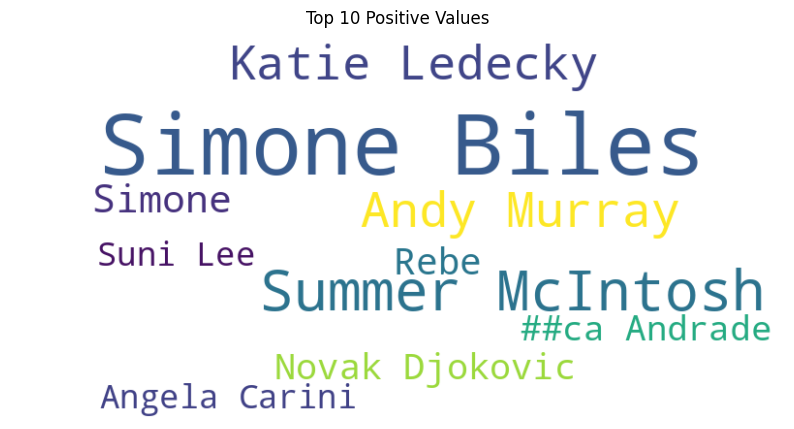

In [138]:
visualize_top_10_keys(positive_dict,True)

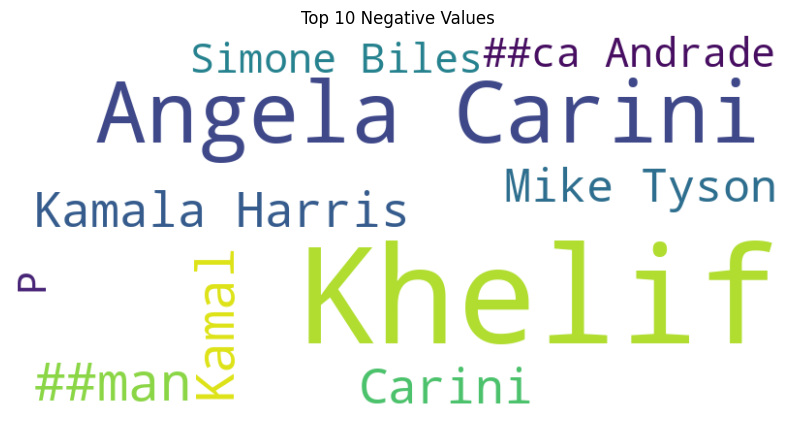

In [139]:
visualize_top_10_keys(negative_dict,False)